In [1]:
import pickle
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from stop_words import get_stop_words
import Stemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import linear_model as lm
from sklearn import ensemble
from sklearn import metrics
from sklearn.decomposition import RandomizedPCA
from sklearn.manifold import TSNE
import xgboost as xgb 
from gensim import corpora, models
from segtok import segmenter
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import glob
from collections import defaultdict
import copy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.advanced_activations import PReLU
from keras.optimizers import SGD
from gensim.models import word2vec
import config
%matplotlib inline

Using Theano backend.


In [92]:
def read_posts(domain=None, filename=None):
    if not filename:
        if domain:
            filename = 'data/{}.pkl'.format(domain)
        else:
            raise Exception('Wrong arguments')
    with open(filename, 'rb') as f:
        posts = pickle.load(f)
    return posts


def get_label(q_1, q_2, likes):
    if likes < q_1:
        return 0
    elif likes < q_2:
        return 1
    else:
        return 2


def set_labels(df):
    grouped = df.groupby('domain')
    df['label'] = None
    for group_name, idx in grouped.groups.items():
        q_1 = df.loc[idx, 'likes'].quantile(1 / 3)
        q_2 = df.loc[idx, 'likes'].quantile(2 / 3)
        df.loc[idx, 'label'] = df.loc[idx, 'likes'].apply(lambda x: get_label(q_1, q_2, x))
    return df

        
def generate_dataframe(posts):
    texts = [post['text'] for post in posts]
    dates = [datetime.fromtimestamp(p['date']) for p in posts]
    likes = [post['likes'] for post in posts]
    reposts = [p['reposts'] for p in posts]
    domains = [p['domain'] for p in posts]
    
    df = pd.DataFrame({'text': texts, 'date': dates, 'likes': likes, 'reposts': reposts,
                       'domain': domains})
    df = set_labels(df)
    return df


def plot_date_likes(df, with_reps=True):
    fig, ax = plt.subplots(figsize=(12, 8))
    

    years = YearLocator()   # every year
    months = MonthLocator()  # every month
    yearsFmt = DateFormatter('%Y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)

    ax.set_xlabel('Year')
    ax.set_ylabel('Likes')
    ax.set_title('Horror stories')
    ax.set_ylim((0, 3000))

    ax.plot_date(df[df.label==0].date, df[df.label==0].likes, ',', label='label 0', color='red', alpha=0.9)
    ax.plot_date(df[df.label==1].date, df[df.label==1].likes, ',', label='label 1', color='green', alpha=0.9)
    ax.plot_date(df[df.label==2].date, df[df.label==2].likes, ',', label='label 2', color='blue', alpha=0.9)
    plt.legend()

### Reading data

In [114]:
all_posts = read_posts('all_posts')
posts = generate_dataframe(all_posts)
dataset_posts = read_posts('dataset')
dataset = generate_dataframe(dataset_posts)
posts.shape, dataset.shape

((25595, 6), (20935, 6))

Labels:
* 0: post which has less than 0.33 percentile likes
* 1: post which has greater than 0.33 and less than 0.67 percentile likes
* 2: post which has greater than 0.67 percentile likes

Percentiles are calculated separately for each domain

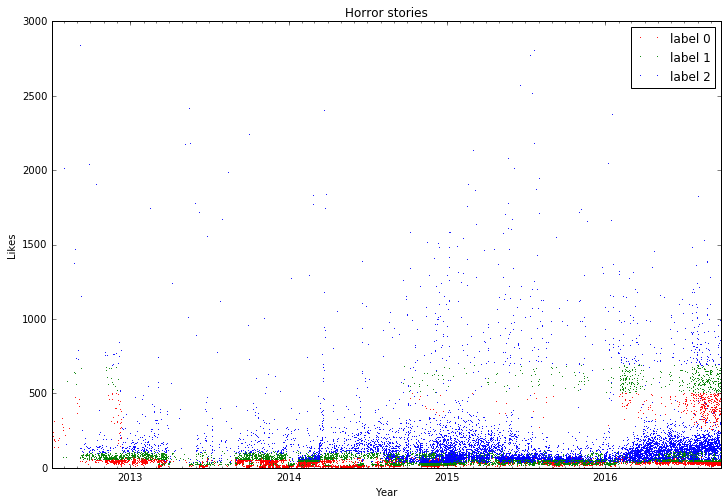

In [4]:
plot_date_likes(posts)

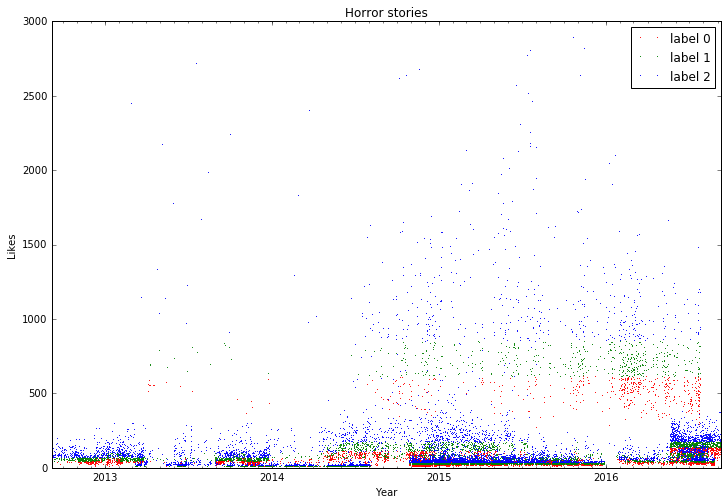

In [5]:
plot_date_likes(dataset)

Correlation between likes and reposts

In [6]:
posts.corr()['likes']['reposts']

0.73114029638399658

## Text processing

### Getting names

For filtering names from the dataset we find all words, which start with an upper case letter and not at the beginning of the sentence.

In [115]:
def without_first_word_texts(texts, with_stemmer=True):
    cleared_texts = []
    stop_words = get_stop_words('ru')
    stemmer = Stemmer.Stemmer('russian')

    for text in texts:
        sentences = segmenter.split_single(re.sub('( \n \n)|( \n\n)', '\n', text))
        cleared_text = []
        for sentence in sentences:
            sentence = re.sub('[^а-яА-ЯёЁ]', ' ', sentence)
            sentence = sentence.split()
            sentence = [s for s in sentence if s not in stop_words]
            if with_stemmer:
                sentence = stemmer.stemWords(sentence)
            if len(sentence) > 1:
                cleared_text.extend(sentence[1:])
        cleared_texts.append(cleared_text)
    return cleared_texts

In [8]:
%time without_first = without_first_word_texts(posts.text.values)

CPU times: user 6min 30s, sys: 576 ms, total: 6min 30s
Wall time: 6min 31s


In [9]:
dictionary = corpora.Dictionary(without_first)
print(dictionary)

Dictionary(92195 unique tokens: ['пролепета', 'развветк', 'гримир', 'ПРОСМОТРЕВШИХ', 'батареек']...)


In [10]:
dictionary_filtered = copy.deepcopy(dictionary)

In [11]:
dictionary_filtered.filter_extremes(no_below=20, no_above=0.1)

In [12]:
print(dictionary_filtered)

Dictionary(20953 unique tokens: ['эксцентричн', 'поборот', 'пролепета', 'отслуж', 'содрога']...)


In [13]:
names = [name for name in dictionary_filtered.token2id.keys() if len(name) > 2 and name[0].isupper()\
         and name[1:].islower()]

In [14]:
len(names)

1614

In [15]:
with open('names_from_sent.txt', 'w') as f:
    f.write('\n'.join(sorted([name.lower() for name in names])))

After that, I do some cleaning by hands. From 1600 words (with countries names etc) to 800.

### Clearing texts

In [116]:
def clear_texts(texts, with_stemmer=True, to_lower=True, without_names=True, without_stop_words=True,
                min_word_len=3):
    clear_texts = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    
    with open('names_from_sent.txt', 'r') as f:
        names = f.readlines()
        names = set([name.strip() for name in names])
    
    names_del = 0
    for text in texts:
        if to_lower:
            text = text.lower()
        text = re.sub('[^а-яА-ЯёЁ]', ' ', text)
        text = text.split()
        if without_stop_words:
            text = [t for t in text if t not in stop_words]
        if with_stemmer:
            text = stemmer.stemWords(text)
            if without_names:
                before = len(text)
                text = [t for t in text if t not in names]
                aft = len(text)
                names_del += before - aft
        if min_word_len is not None:
            text = [t for t in text if len(t) >= min_word_len]
        clear_texts.append(' '.join(text))
    print('names del: {}'.format(names_del))
    return clear_texts

In [6]:
%%time
stemmed_posts_texts = clear_texts(posts.text.values, True)

names del: 3380627
CPU times: user 41.1 s, sys: 24 ms, total: 41.2 s
Wall time: 41.2 s


In [98]:
%%time
posts_texts = clear_texts(posts.text.values, False, without_names=False, min_word_len=None,
                          without_stop_words=False)

names del: 0
CPU times: user 10.5 s, sys: 64 ms, total: 10.6 s
Wall time: 10.6 s


In [117]:
%%time
stemmed_dataset_texts = clear_texts(dataset.text.values, True)

names del: 352770
CPU times: user 31.8 s, sys: 0 ns, total: 31.8 s
Wall time: 31.8 s


In [118]:
%%time
dataset_texts = clear_texts(dataset.text.values, False)

names del: 0
CPU times: user 11.6 s, sys: 0 ns, total: 11.6 s
Wall time: 11.6 s


Total words:

In [7]:
sum([len(t.split()) for t in stemmed_posts_texts])

6043050

In [20]:
stemmed_dataset_texts[0][:400]

'общаг общежит засел поступ колледж снима вариант поначал нормальн соседк колледж пройт метр общ устраива здан редк остава одн происход одн мож уснут тревог незащищен темнот навод разн начал остава психу выключа кроват стуча листочк тетрад пада наход кра стол вскакива прич впечатлен открыт окн вентиляц закле включа прекраща обе обнаруж банк ложк вилк треснул прич сниз ровн овал найт разумн объяснен'

## Getting features

### Train test split

In [119]:
x_train, x_test, y_train, y_test = train_test_split(stemmed_dataset_texts, dataset.label.values,
                                                    random_state=10, train_size=0.8)

In [120]:
x_train_no_stem, x_test_no_stem, y_train, y_test = train_test_split(dataset_texts, dataset.label.values,
                                                    random_state=10, train_size=0.8)

In [423]:
pd.DataFrame({'y': y_train}).to_csv('features/y_train.csv.gz', index=False, compression='gzip')
pd.DataFrame({'y': y_test}).to_csv('features/y_test.csv.gz', index=False, compression='gzip')

## Tfidf

In [207]:
%%time
vect = TfidfVectorizer(max_features=1000, ngram_range=(1, 3), min_df=20, max_df=0.2)
#vect = CountVectorizer(max_features=1000, ngram_range=(1, 3), min_df=20, max_df=0.2)

X_train_Tfidf = vect.fit_transform(x_train)
X_test_Tfidf = vect.transform(x_test)

CPU times: user 1min 13s, sys: 1.96 s, total: 1min 15s
Wall time: 1min 20s


In [424]:
pd.DataFrame(X_train_Tfidf.toarray()).to_csv('features/X_train_Tfidf.csv.gz', index=False, compression='gzip')
pd.DataFrame(X_test_Tfidf.toarray()).to_csv('features/X_test_Tfidf.csv.gz', index=False, compression='gzip')

In [208]:
vocab = vect.get_feature_names()
dist = np.mean(X_train_Tfidf.toarray(), axis=0)
vocab_dist = dict(zip(vocab, dist))

Highest Tfidf:

In [209]:
sorted(vocab_dist.items(), key=lambda i: -i[1])[:5]

[('девочк', 0.031190036871565265),
 ('бабушк', 0.030571152808370829),
 ('муж', 0.023059077764828764),
 ('мальчик', 0.021075481251638488),
 ('подруг', 0.021016168405234781)]

Lowest Tfidf:

In [210]:
sorted(vocab_dist.items(), key=lambda i: i[1])[:5]

[('кивнул', 0.0033676919887659102),
 ('гот', 0.0035675988790125992),
 ('произнес', 0.0036503703951354634),
 ('обеща', 0.0037312462821721512),
 ('прижа', 0.003735149386929322)]

### DELETE

In [15]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'booster': 'gbtree',
    'eval_matrics': 'accuracy',
}

In [16]:
%%time
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

gbm = xgb.train(params, dtrain, 100, watchlist, verbose_eval=True, early_stopping_rounds=30)

Will train until eval error hasn't decreased in 30 rounds.
[0]	train-merror:0.565251	eval-merror:0.617692
[1]	train-merror:0.530922	eval-merror:0.606229
[2]	train-merror:0.508694	eval-merror:0.608903
[3]	train-merror:0.488950	eval-merror:0.604127
[4]	train-merror:0.476021	eval-merror:0.606420
[5]	train-merror:0.463346	eval-merror:0.603936
[6]	train-merror:0.448124	eval-merror:0.602025
[7]	train-merror:0.435577	eval-merror:0.599350
[8]	train-merror:0.420610	eval-merror:0.594956
[9]	train-merror:0.406853	eval-merror:0.595147
[10]	train-merror:0.398319	eval-merror:0.593237
[11]	train-merror:0.389657	eval-merror:0.589033
[12]	train-merror:0.383033	eval-merror:0.594192
[13]	train-merror:0.374562	eval-merror:0.594383
[14]	train-merror:0.368320	eval-merror:0.597822
[15]	train-merror:0.360869	eval-merror:0.593045
[16]	train-merror:0.353863	eval-merror:0.596485
[17]	train-merror:0.349659	eval-merror:0.596102
[18]	train-merror:0.342526	eval-merror:0.594574
[19]	train-merror:0.335265	eval-merror:

CPU times: user 1min 24s, sys: 32 ms, total: 1min 24s
Wall time: 23.5 s


[41]	train-merror:0.259538	eval-merror:0.589606
Stopping. Best iteration:
[11]	train-merror:0.389657	eval-merror:0.589033



In [9]:
pred = gbm.predict(dvalid)

In [21]:
list(filter(lambda x: x[1] == 9, vect.vocabulary_.items()))

[('бабушк', 9)]

In [17]:
sorted(gbm.get_fscore().items(), key=lambda x: -x[1])

[('f855', 54),
 ('f17', 26),
 ('f0', 22),
 ('f183', 22),
 ('f9', 19),
 ('f77', 18),
 ('f84', 18),
 ('f966', 17),
 ('f74', 17),
 ('f201', 17),
 ('f447', 17),
 ('f419', 17),
 ('f398', 16),
 ('f15', 16),
 ('f288', 15),
 ('f944', 15),
 ('f71', 15),
 ('f67', 14),
 ('f616', 14),
 ('f28', 14),
 ('f81', 13),
 ('f192', 13),
 ('f792', 13),
 ('f321', 13),
 ('f55', 13),
 ('f660', 13),
 ('f159', 13),
 ('f204', 13),
 ('f816', 13),
 ('f412', 13),
 ('f345', 13),
 ('f101', 12),
 ('f66', 12),
 ('f38', 12),
 ('f462', 12),
 ('f499', 12),
 ('f656', 12),
 ('f503', 12),
 ('f303', 12),
 ('f831', 12),
 ('f595', 11),
 ('f762', 11),
 ('f573', 11),
 ('f798', 11),
 ('f169', 11),
 ('f296', 11),
 ('f103', 11),
 ('f307', 11),
 ('f108', 11),
 ('f620', 11),
 ('f742', 11),
 ('f679', 11),
 ('f68', 11),
 ('f497', 10),
 ('f83', 10),
 ('f927', 10),
 ('f956', 10),
 ('f877', 10),
 ('f32', 10),
 ('f34', 10),
 ('f529', 10),
 ('f492', 10),
 ('f835', 10),
 ('f100', 10),
 ('f191', 10),
 ('f4', 10),
 ('f280', 10),
 ('f913', 10),
 (

### END DELETE

In [211]:
tsne = TSNE(2)

In [212]:
x_tsne = tsne.fit_transform(X_train_Tfidf[:5000].toarray())

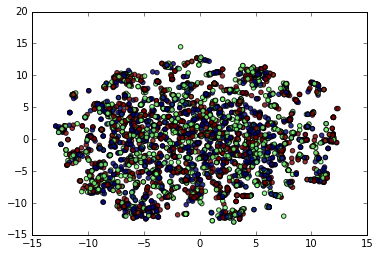

In [228]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train[:5000], alpha=0.8)

In [216]:
%%time
lr = lm.LogisticRegression(C=0.01)
lr.fit(X_train_Tfidf, y_train)
pred = lr.predict(X_test_Tfidf)


CPU times: user 344 ms, sys: 8 ms, total: 352 ms
Wall time: 349 ms


In [218]:
metrics.accuracy_score(y_test, pred)

0.40386911870074038

## NN

In [399]:
y_train_cat = np_utils.to_categorical(y_train, 3)
y_test_cat = np_utils.to_categorical(y_test, 3)

In [400]:
model = Sequential()
model.add(Dense(700, input_shape=(1000,)))
model.add(Activation(PReLU()))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [401]:
%%time
history = model.fit(X_train_Tfidf.toarray(), y_train_cat,
                    nb_epoch=5, batch_size=512,
                    verbose=1) #, validation_split=0.1)

Epoch 1/5
16748/16748 [==============================] - 3s - loss: 1.0862 - acc: 0.3903     
Epoch 2/5
16748/16748 [==============================] - 3s - loss: 1.0465 - acc: 0.4663     
Epoch 3/5
16748/16748 [==============================] - 3s - loss: 1.0201 - acc: 0.4879     
Epoch 4/5
16748/16748 [==============================] - 3s - loss: 0.9959 - acc: 0.5094     
Epoch 5/5
16748/16748 [==============================] - 3s - loss: 0.9719 - acc: 0.5300     
CPU times: user 27.6 s, sys: 28.7 s, total: 56.4 s
Wall time: 17.7 s


In [402]:
score = model.evaluate(X_test_Tfidf.toarray(), y_test_cat,
                       batch_size=512, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

4187/4187 [==============================] - 0s     
Test score: 1.072735984
Test accuracy: 0.413900167376


In [238]:
pred = model.predict_classes(X_test_Tfidf.toarray(), batch_size=512)

4096/4187 [============================>.] - ETA: 0s

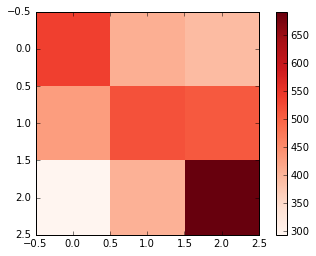

In [239]:
matr = metrics.confusion_matrix(y_test, pred)
plt.imshow(matr, interpolation='nearest', cmap=plt.cm.Reds)
plt.colorbar()

## LDA Model

## Filtering dictionary

In [28]:
splited_texts = [text.split() for text in stemmed_posts_texts]
dictionary = corpora.Dictionary(splited_texts)
corpus = [dictionary.doc2bow(text) for text in splited_texts]
print(dictionary)

Dictionary(79844 unique tokens: ['мерзнут', 'загуд', 'снек', 'завсклад', 'рыжеволос']...)


In [29]:
dictionary_filtered = copy.deepcopy(dictionary)
dictionary_filtered.filter_extremes(no_below=20, no_above=0.1)

If not filtered names and short words before

In [30]:
with open('names_from_sent.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]
names_ids = []
for name in names:
    try:
        names_ids.append(dictionary_filtered.token2id[name])
    except:
        pass
dictionary_filtered.filter_tokens(bad_ids=names_ids)

In [31]:
short_token_ids = [id for token, id in dictionary_filtered.token2id.items() if len(token) < 3]
len(short_token_ids)

0

In [32]:
dictionary_filtered.filter_tokens(bad_ids=short_token_ids)
print(dictionary_filtered)

Dictionary(19254 unique tokens: ['мерзнут', 'низк', 'послевоен', 'вложен', 'проникновен']...)


In [33]:
dict_count_before= len(dictionary)
corpus_size_before = sum([word[1] for document in corpus for word in document])

In [34]:
corpus = [dictionary_filtered.doc2bow(text) for text in splited_texts]
dict_count_after = len(dictionary_filtered)
corpus_size_after = sum([word[1] for document in corpus for word in document])

### After filtering

In [35]:
print('Dictionary size\nBefore: {}; after: {}\nCorpus size\nBefore: {}; after: {}'.format(
      dict_count_before, dict_count_after, corpus_size_before, corpus_size_after))

Dictionary size
Before: 79844; after: 19254
Corpus size
Before: 6043050; after: 4336094


In [36]:
dictionary_filtered.save('models_bin/dictionary_filtered')

## Model

If already trained before

In [37]:
dictionary_filtered = corpora.Dictionary.load('models_bin/dictionary_filtered')

In [38]:
%%time
splited_texts = [text.split() for text in stemmed_posts_texts]
corpus = [dictionary_filtered.doc2bow(text) for text in splited_texts]

CPU times: user 8.89 s, sys: 180 ms, total: 9.07 s
Wall time: 9.08 s


In [108]:
%%time
ldamodel = models.LdaModel(corpus, id2word=dictionary_filtered, num_topics=100, passes=50,
                                                  alpha='auto', eta='auto')

CPU times: user 2h 39min 57s, sys: 4h 49min 12s, total: 7h 29min 9s
Wall time: 2h 9min 11s


In [109]:
ldamodel.save('models_bin/lda')

In [39]:
ldamodel = models.LdaModel.load('models_bin/lda')

In [121]:
for i, topic in ldamodel.show_topics(num_topics=100, num_words=5, formatted=False):
    print("Topic " + str(i) + ': ')
    for word, p in topic:
        print(word, p)

Topic 0: 
нежн 0.00407562625664
опуст 0.00405112070126
губ 0.00404624085593
мерзк 0.00335867869005
улыбнул 0.00335059516643
Topic 1: 
вагон 0.0494769251661
электричк 0.0179211332435
тоннел 0.0128343685992
пассажир 0.0126030751294
сумк 0.0117768727602
Topic 2: 
незнакомец 0.0197266948675
шляп 0.0165146015073
юнош 0.0147169870689
незнакомц 0.0106928569065
коп 0.00979636718716
Topic 3: 
балкон 0.026482382523
ключ 0.0250729873684
входн 0.0147749259507
площадк 0.0142726807687
ручк 0.0139402488656
Topic 4: 
мяс 0.0517987944559
вкусн 0.0156952244778
голод 0.0130289119977
съел 0.0107677799036
блюд 0.00987645827467
Topic 5: 
зеркал 0.0699687010892
отражен 0.0693863446228
стекл 0.0368283414202
отража 0.0125239173765
зеркальн 0.0118956855874
Topic 6: 
труб 0.0285230767071
июл 0.0152907662158
кана 0.00964428408648
хрен 0.00880054171089
шипен 0.00681247630183
Topic 7: 
коф 0.0102814975899
чайник 0.00657297213193
чашк 0.00518832026018
кружк 0.00500943378038
сумк 0.00488299546912
Topic 8: 
могил 0.06

In [127]:
print(sorted(posts.text, key=len)[10])

Над нами не небо
Над нами земля
Сидим здесь и ждём мы
Судного дня
Мы верим в победу
Мы верим главе
Мы служим правителю
Ему,Сатане
Веками мы жаждали день отмщения
Когда вновь увидим мы солнца свечение
Когда под влиянием адских сил тьмы 
На землю ворвётся легион Сатаны
И будем мы сеять разруху и смерть
И кровью затопим бетонную твердь
Праведник,грешник без разницы нам
На нашем пути всех порвём пополам
И с силами света скрестим мы мечи
Готовьтесь святоши,ведь дни сочтены
Мы будем сражаться за полный контроль
Врагам предоставим лишь страх мы и боль
И ознаменуем мы новую эру
Садизма и смерти
Хвала Люциферу!


In [128]:
(posts.text == sorted(posts.text, key=len)[10]).argmax()

8650

In [129]:
ldamodel.get_document_topics(list(corpus)[8650], minimum_probability=0.05)  # 994 666

[(5, 0.067236003295404315),
 (11, 0.071303583302979825),
 (17, 0.099989639925973969),
 (68, 0.26965271569839255),
 (88, 0.11139765908173584)]

In [130]:
topic = ldamodel.show_topic(68, 10) # 60 89 94
for word, p in topic:
    print(word, p)

желан 0.00418436105998
договор 0.00361594112577
язык 0.00356701942716
числ 0.00335387153302
обязательн 0.00327054155281
услов 0.00319434652678
грех 0.00290955247629
исполн 0.00283516359889
княз 0.00280812985323
пентаграмм 0.00278725096603


In [113]:
perplexity = ldamodel.log_perplexity(list(corpus))
print(2**(-perplexity))

432.791015748


### Validation

In [241]:
def get_corpus_matrix(model, corpus):
    matrix = np.zeros((len(corpus), model.num_topics))
    for i in range(len(corpus)):
        doc_topics = model.get_document_topics(list(corpus)[i], minimum_probability=0.05)
        for topic_id, prob in doc_topics:
            matrix[i, topic_id] = prob
    return matrix

In [249]:
%%time
splited_train_texts = [text.split() for text in x_train]
corpus_train_dataset = [dictionary_filtered.doc2bow(text) for text in splited_train_texts]
splited_test_texts = [text.split() for text in x_test]
corpus_test_dataset = [dictionary_filtered.doc2bow(text) for text in splited_test_texts]

CPU times: user 9.71 s, sys: 352 ms, total: 10.1 s
Wall time: 23.1 s


In [250]:
len(corpus_train_dataset), len(corpus_test_dataset)

(16748, 4187)

In [251]:
%%time
X_train_lda = get_corpus_matrix(ldamodel, corpus_train_dataset)
X_test_lda = get_corpus_matrix(ldamodel, corpus_test_dataset)

CPU times: user 5min 32s, sys: 10min 55s, total: 16min 28s
Wall time: 4min 26s


In [425]:
pd.DataFrame(X_train_lda).to_csv('features/X_train_lda.csv.gz', index=False, compression='gzip')
pd.DataFrame(X_test_lda).to_csv('features/X_test_lda.csv.gz', index=False, compression='gzip')

In [278]:
tsne = TSNE()
points = tsne.fit_transform(X_train_lda[:5000,:])

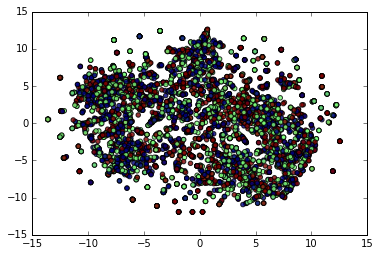

In [279]:
plt.scatter(pointsts[:, 0], points[:, 1], c=y_train[:5000], alpha=0.8)

In [255]:
%%time
lr = lm.LogisticRegression()
lr.fit(X_train_lda, y_train)
pred = lr.predict(X_test_lda)

CPU times: user 232 ms, sys: 4 ms, total: 236 ms
Wall time: 251 ms


In [256]:
metrics.accuracy_score(y_test, pred)

0.40028660138524003

In [273]:
%%time
lr = ensemble.GradientBoostingClassifier(n_estimators=500)
lr.fit(X_train_lda, y_train)
pred = lr.predict(X_test_lda)

CPU times: user 1min 59s, sys: 92 ms, total: 1min 59s
Wall time: 2min


In [274]:
metrics.accuracy_score(y_test, pred)

0.4119894912825412

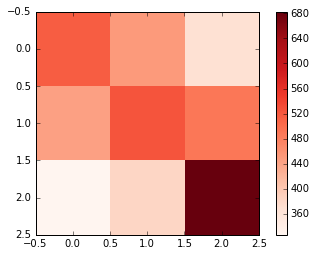

In [275]:
matr = metrics.confusion_matrix(y_test, pred)
plt.imshow(matr, interpolation='nearest', cmap=plt.cm.Reds)
plt.colorbar()

# word2vec

In [281]:
def clear_sentences(texts, with_stemmer=False, to_lower=True, min_word_in_sent=3):
    cleared_sentences = []
    stop_words = get_stop_words('ru')
    stemmer = Stemmer.Stemmer('russian')

    for text in texts:
        sentences = segmenter.split_single(re.sub('( \n \n)|( \n\n)', '\n', text))
        for sentence in sentences:
            if to_lower:
                sentence = sentence.lower()
            sentence = re.sub('[^а-яА-ЯёЁ]', ' ', sentence)
            sentence = sentence.split()
            if len(sentence) >= min_word_in_sent:
                cleared_sentences.append(sentence) 
    return cleared_sentences

In [328]:
%time clear_sent = clear_sentences(posts.text)

CPU times: user 4min 50s, sys: 20.9 s, total: 5min 11s
Wall time: 12min 59s


In [329]:
print(posts_texts[-1])

со мной однажды произошёл совершенно невероятный случай которому до сих пор не могу найти объяснения я возвращался домой с работы ещё было светло а у меня надо сказать давно уже привычка смотреть на своё окно с улицы смотрю а в моём окне на девятом этаже стою я сам и на меня смотрю причём в той же ярко жёлтой рубашке что и в тот момент на мне была странно но я почти не испугался в тот момент просто удивился видимо сказывалось то что я на светлой людной улице когда я вошёл в квартиру естественно там никого не было только потом когда я осознал всю странность ситуации мне стало сильно не по себе


In [330]:
clear_sent[-1]

['только',
 'потом',
 'когда',
 'я',
 'осознал',
 'всю',
 'странность',
 'ситуации',
 'мне',
 'стало',
 'сильно',
 'не',
 'по',
 'себе']

In [286]:
%time model = word2vec.Word2Vec(clear_sent, size=200)

CPU times: user 8min 22s, sys: 548 ms, total: 8min 22s
Wall time: 3min 30s


In [61]:
model.save('models_bin/word2vec')

In [91]:
model = word2vec.Word2Vec.load('models_bin/word2vec')

In [428]:
model.most_similar('смерть')

[('болезнь', 0.6736840605735779),
 ('месть', 0.5838950872421265),
 ('жертва', 0.5642502307891846),
 ('участь', 0.5607681274414062),
 ('любовь', 0.5381002426147461),
 ('гибель', 0.5165857672691345),
 ('порча', 0.5033100843429565),
 ('судьба', 0.49604398012161255),
 ('внешность', 0.4917110204696655),
 ('личность', 0.4873163402080536)]

In [289]:
model.most_similar('мясо')

[('вино', 0.5631377696990967),
 ('сочное', 0.5536653399467468),
 ('кольцо', 0.5347784757614136),
 ('молоко', 0.534410834312439),
 ('покрывало', 0.511174201965332),
 ('оружие', 0.5061862468719482),
 ('печенье', 0.5052534341812134),
 ('сырое', 0.505222737789154),
 ('блюдо', 0.4968991279602051),
 ('свежее', 0.4949791431427002)]

In [290]:
model.most_similar(positive=['пиво', 'водка'])

[('вино', 0.7027807235717773),
 ('водку', 0.6873305439949036),
 ('шашлык', 0.6841100454330444),
 ('жарить', 0.6624295115470886),
 ('разлили', 0.6617324352264404),
 ('пожарили', 0.6495035886764526),
 ('поели', 0.6385335922241211),
 ('мангал', 0.6359939575195312),
 ('пиццу', 0.6358096599578857),
 ('лимонад', 0.6318403482437134)]

### Validation

In [101]:
def get_vector_from_words(words, model, num_features):
    features = np.zeros((num_features,), dtype=np.float32)
    n = 0
    index2word = set(model.index2word)
    
    for word in words:
        if word in index2word:
            features += model[word]
            n += 1
    return features / n

In [102]:
def get_texts_vectors(texts, model, num_features):
    texts_vectors = np.zeros((len(texts), num_features), dtype=np.float32)
    
    i = 0
    for text in texts:
        texts_vectors[i] = get_vector_from_words(text.split(), model, num_features)
        i += 1
    return texts_vectors

In [121]:
x_train_no_stem[1][:200]

'ольга шла улице новороссийской забрела случайно улице стоял сильный зной девушке сильно хотелось пить кармане денег еле хватало литр сока наверное придётся брать лимонад зайдя попавшийся магазин испыт'

In [122]:
x_train[1][:100]

'шла улиц новороссийск забрел случайн улиц стоя сильн зно девушк сильн хотел карман денег хвата литр '

In [123]:
%%time
X_train_word2vec = get_texts_vectors(x_train_no_stem, model, 200)
X_test_word2vec = get_texts_vectors(x_test_no_stem, model, 200)

CPU times: user 5min 55s, sys: 180 ms, total: 5min 55s
Wall time: 5min 55s


#### Don't forget to drop two rows

In [426]:
pd.DataFrame(X_train_word2vec).to_csv('features/X_train_word2vec.csv.gz', index=False, compression='gzip')
pd.DataFrame(X_test_word2vec).to_csv('features/X_test_word2vec.csv.gz', index=False, compression='gzip')

In [124]:
sorted(np.isnan(X_train_word2vec).sum(axis=1), reverse=True)[:4]

[200, 200, 0, 0]

In [125]:
sorted(np.isnan(X_test_word2vec).sum(axis=1), reverse=True)[:4]

[0, 0, 0, 0]

We see that we have two row with all nan in train. Drop it

In [387]:
not_nan_ind = np.isnan(X_train_word2vec).sum(axis=1) == 0
X_train_word2vec_cl = X_train_word2vec[not_nan_ind]
y_train_cl = y_train[not_nan_ind]

In [390]:
tsne = TSNE()
points = tsne.fit_transform(X_train_word2vec_cl[:5000])

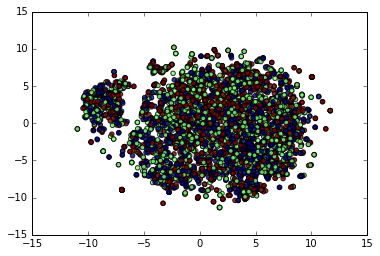

In [391]:
plt.scatter(points[:, 0], points[:, 1], c=y_train_cl[:5000], alpha=0.8)

In [403]:
%%time
lr = lm.LogisticRegression()
lr.fit(X_train_word2vec_cl, y_train_cl)
pred = lr.predict(X_test_word2vec)

CPU times: user 5.01 s, sys: 0 ns, total: 5.01 s
Wall time: 5.49 s


In [404]:
metrics.accuracy_score(y_test, pred)

0.39359923572963934

In [406]:
%%time
lr = ensemble.GradientBoostingClassifier(n_estimators=500)
lr.fit(X_train_word2vec_cl, y_train_cl)
pred = lr.predict(X_test_word2vec)

CPU times: user 10min 48s, sys: 0 ns, total: 10min 48s
Wall time: 10min 49s


In [407]:
metrics.accuracy_score(y_test, pred)

0.41939336040124192

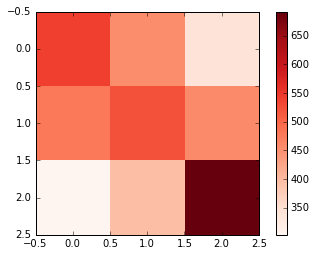

In [408]:
matr = metrics.confusion_matrix(y_test, pred)
plt.imshow(matr, interpolation='nearest', cmap=plt.cm.Reds)
plt.colorbar()